In [ ]:
# !pip install tableone

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from google.cloud import bigquery

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from tableone import TableOne

import warnings
warnings.filterwarnings('ignore')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [16]:
# replace protean-chassis-368116 with your own project id
%env GOOGLE_CLOUD_PROJECT = protean-chassis-368116

env: GOOGLE_CLOUD_PROJECT=protean-chassis-368116


## get mimic-iv data

### look at the pressure ulcer itemids

In [17]:
%%bigquery presure_ulcers

SELECT ce.itemid
, MAX(di.label) AS label
, MAX(di.category) AS category
-- , value
, COUNT(*) AS count

FROM `physionet-data.mimiciv_icu.chartevents` ce
LEFT JOIN `physionet-data.mimiciv_icu.d_items` di
ON ce.itemid = di.itemid
WHERE LOWER(di.label) LIKE "%ulcer%"

GROUP BY itemid--, value
ORDER BY label--, value

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
presure_ulcers

,itemid,label,category,count
0,228610,Pressure Ulcer #1- Depth,Skin - Impairment,20525
1,228506,Pressure Ulcer #1- Location,Skin - Impairment,86946
2,228539,Pressure Ulcer #1- Treatment,Skin - Impairment,57404
3,228549,Pressure Ulcer #1- Type,Skin - Impairment,84098
4,228620,Pressure Ulcer #1- Width,Skin - Impairment,58662
...,...,...,...,...
165,228821,Pressure ulcer #9- Stage,Skin - Impairment,192
166,228751,Pressure ulcer #9- Surrounding tissue,Skin - Impairment,181
167,228841,Pressure ulcer #9- Tunneling present,Skin - Impairment,137
168,228851,Pressure ulcer #9- Undermining present,Skin - Impairment,137


### pressure ulcer and device first reports

In [19]:
%%bigquery ulcer_device

WITH pressure_ulcer_presence AS (

  SELECT *
  FROM(
    SELECT
      ce.stay_id
    , ce.itemid
    , ce.value
    , ce.charttime AS time_first_ulcer_reported
    , ROW_NUMBER() OVER(PARTITION BY ce.stay_id
                          ORDER BY ABS(TIMESTAMP_DIFF(ce.charttime, icu.icu_intime, MINUTE)) ASC) AS seq

    FROM `physionet-data.mimiciv_derived.icustay_detail` icu

    LEFT JOIN `physionet-data.mimiciv_icu.chartevents` ce
    ON ce.stay_id = icu.stay_id

    WHERE ce.itemid IN (
      SELECT di.itemid
      FROM `physionet-data.mimiciv_icu.d_items` di
      WHERE LOWER(di.label) LIKE "%ulcer%"
      AND di.itemid <> 228649  -- removing the admission info
    )
  )
  WHERE seq = 1

),

pressure_ulcer_location AS (

  SELECT

    stay_id
    , STRING_AGG(locations) AS locations

  FROM(
    SELECT
      ce.stay_id
    , ce.itemid
    , ce.value AS locations
    , ROW_NUMBER() OVER(PARTITION BY ce.stay_id
                          ORDER BY ABS(TIMESTAMP_DIFF(ce.charttime, icu.icu_intime, MINUTE)) ASC) AS seq

    FROM `physionet-data.mimiciv_derived.icustay_detail` icu

    LEFT JOIN `physionet-data.mimiciv_icu.chartevents` ce
    ON ce.stay_id = icu.stay_id

    WHERE ce.itemid IN (
      SELECT di.itemid
      FROM `physionet-data.mimiciv_icu.d_items` di
      WHERE LOWER(di.label) LIKE "%ulcer%"
      AND LOWER(di.label) LIKE "%location%"
      AND di.itemid <> 228649  -- removing the admission info
    )
  )

  GROUP BY stay_id

),

device_presence AS (

  SELECT *
  FROM(
    SELECT
      ce.stay_id
    , ce.itemid
    , ce.value AS type_device
    , ce.charttime AS time_first_device_reported
    , ROW_NUMBER() OVER(PARTITION BY ce.stay_id
                          ORDER BY ABS(TIMESTAMP_DIFF(ce.charttime, icu.icu_intime, MINUTE)) ASC) AS seq

    FROM `physionet-data.mimiciv_derived.icustay_detail` icu

    LEFT JOIN `physionet-data.mimiciv_icu.chartevents` ce
    ON ce.stay_id = icu.stay_id

    WHERE ce.itemid IN (
      SELECT di.itemid
      FROM `physionet-data.mimiciv_icu.d_items` di
      WHERE LOWER(label) LIKE "%pressure reducing%"
    )
    AND ce.value <> "None"
  )
  WHERE seq = 1

)

SELECT

    icu.subject_id
  , icu.hadm_id
  , icu.stay_id
  , detail.admission_age
  , CASE
      WHEN (
         LOWER(detail.race) LIKE "%white%"
      OR LOWER(detail.race) LIKE "%portuguese%"
      OR LOWER(detail.race) LIKE "%caucasian%"
      ) THEN "White"
      WHEN (
         LOWER(detail.race) LIKE "%black%"
      OR LOWER(detail.race) LIKE "%african american%"
      ) THEN "Black"
      WHEN (
         LOWER(detail.race) LIKE "%hispanic%"
      OR LOWER(detail.race) LIKE "%south american%"
      ) THEN "Hispanic"
      WHEN (
         LOWER(detail.race) LIKE "%asian%"
      ) THEN "Asian"
      ELSE "Other"
    END AS race_group
  , detail.gender
  , pu.time_first_ulcer_reported
  , pl.locations
  , dv.time_first_device_reported
  , dv.type_device

FROM `physionet-data.mimiciv_icu.icustays` icu

LEFT JOIN `physionet-data.mimiciv_derived.icustay_detail` detail
ON detail.stay_id = icu.stay_id

LEFT JOIN pressure_ulcer_presence AS pu
ON pu.stay_id = icu.stay_id

LEFT JOIN pressure_ulcer_location AS pl
ON pl.stay_id = icu.stay_id

LEFT JOIN device_presence AS dv
ON dv.stay_id = icu.stay_id

LEFT JOIN `physionet-data.mimiciv_icu.d_items` di
ON di.itemid = pu.itemid

ORDER BY subject_id, hadm_id, stay_id

Query is running:   0%|          |

Downloading:   0%|          |

In [20]:
ulcer_device.head()

,subject_id,hadm_id,stay_id,admission_age,race_group,gender,time_first_ulcer_reported,locations,time_first_device_reported,type_device
0,10000032,29079034,39553978,52,White,F,NaT,None,NaT,None
1,10000980,26913865,39765666,76,Black,F,NaT,None,2189-06-27 09:20:00,Multipodis Boots
2,10001217,24597018,37067082,55,White,F,NaT,None,NaT,None
3,10001217,27703517,34592300,55,White,F,NaT,None,NaT,None
4,10001725,25563031,31205490,46,White,F,NaT,None,NaT,None


### map locations

In [21]:
mappings = {
    'Coccyx': 'Sacral/Coccyx',
    'Gluteal - Left': 'Buttocks',
    'Gluteal - Right': 'Buttocks',
    'Heel - Left': 'Heel',
    'Heel - Right': 'Heel',
    'Hip - Left': 'Other',
    'Hip - Right': 'Other',
    'Iliac Crest - Left': 'Other',
    'Iliac Crest - Right': 'Other',
    'Ischial - Left': 'Buttocks',
    'Ischial - Right': 'Buttocks',
    'Sacrum': 'Sacral/Coccyx',
    'Scapula - Left': 'Other',
    'Scapula - Right': 'Other',
    'Ankle Lateral - Left': 'Other',
    'Ankle Lateral - Right': 'Other',
    'Ankle Medial - Left': 'Other',
    'Ankle Medial - Right': 'Other',
    'Back - Lower': 'Other',
    'Back - Upper': 'Other',
    'Elbow - Left': 'Other',
    'Elbow - Right': 'Other',
    'Lower leg - Left': 'Other',
    'Lower leg - Right': 'Other',
    'Occipital': 'Other',
    'Shoulder - Left': 'Other',
    'Shoulder - Right': 'Other',
    'Foot - Left': 'Other',
    'Foot - Right': 'Other'
}


In [22]:
def map_includes(x):
    if x is None:
        return 0
    return any(item in x for item in mappings.keys())

def categorize(x):
    if x is None:
        return ''
    categories = [mappings[item] for item in mappings if item in x]
    return ';'.join(set(categories))


ulcer_device['relevant_location'] = ulcer_device['locations'].apply(map_includes).astype(int)
ulcer_device['category_location'] = ulcer_device['locations'].apply(categorize)


In [23]:
ulcer_device.head()

,subject_id,hadm_id,stay_id,admission_age,race_group,gender,time_first_ulcer_reported,locations,time_first_device_reported,type_device,relevant_location,category_location
0,10000032,29079034,39553978,52,White,F,NaT,None,NaT,None,0,
1,10000980,26913865,39765666,76,Black,F,NaT,None,2189-06-27 09:20:00,Multipodis Boots,0,
2,10001217,24597018,37067082,55,White,F,NaT,None,NaT,None,0,
3,10001217,27703517,34592300,55,White,F,NaT,None,NaT,None,0,
4,10001725,25563031,31205490,46,White,F,NaT,None,NaT,None,0,


## cleaning

In [24]:
ulcer_device = ulcer_device[ulcer_device.race_group != "Other"]

In [25]:
ulcer_device['has_device'] = ulcer_device.type_device.notna()

## eda

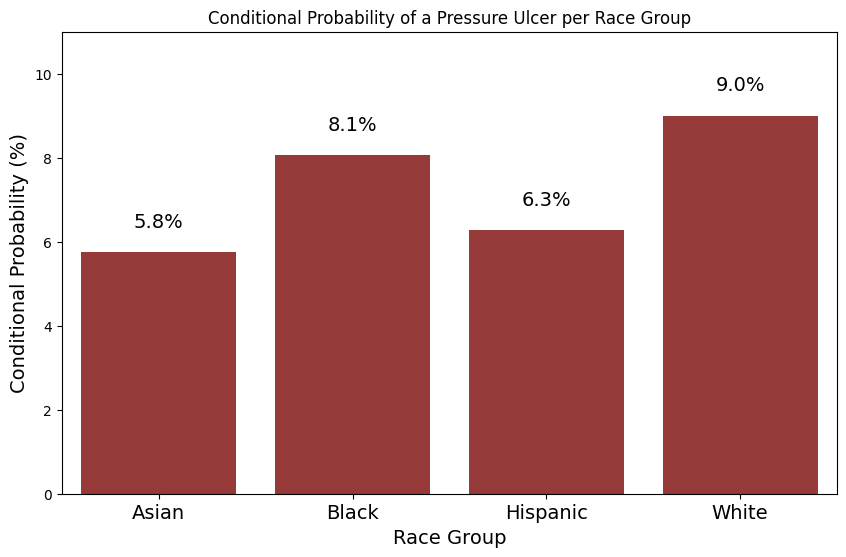

In [26]:
grouped = ulcer_device.groupby('race_group').apply(
    lambda x: (x['relevant_location'].sum() / x['relevant_location'].count()) * 100
).reset_index(name='percentage')

# Create a histogram using seaborn
plt.figure(figsize=(10,6))
ax = sns.barplot(x='race_group', y='percentage', data=grouped, color='brown')

# Adding data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.1f}%'.format(height),
            ha='center', va='bottom', fontsize=14)

plt.title("Conditional Probability of a Pressure Ulcer per Race Group")
plt.xlabel("Race Group", fontsize=14)
plt.ylabel("Conditional Probability (%)", fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([0,11])
plt.show()


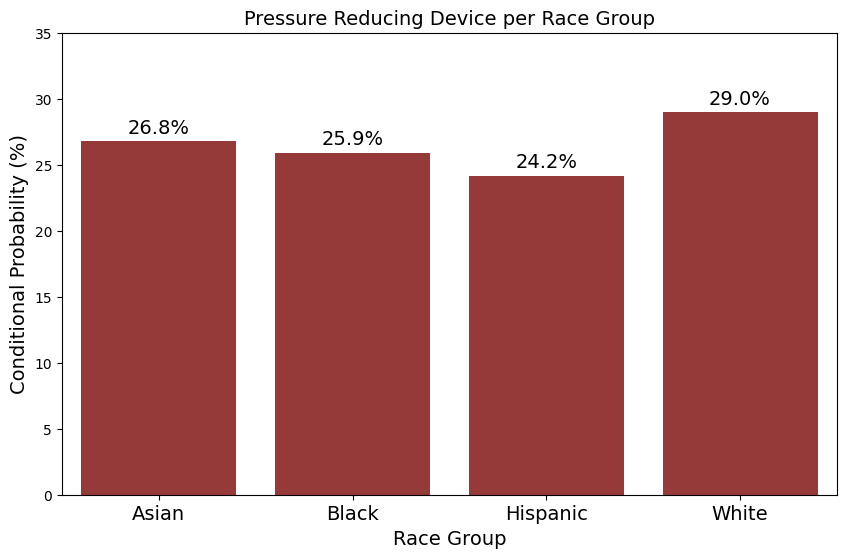

In [27]:
grouped_device = ulcer_device.groupby('race_group').apply(
    lambda x: (x['has_device'].sum() / x['has_device'].count()) * 100
).reset_index(name='device_percentage')

# Create a histogram using seaborn
plt.figure(figsize=(10,6))
ax = sns.barplot(x='race_group', y='device_percentage', data=grouped_device,
                 color='brown')

# Adding data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.3, '{:1.1f}%'.format(height),
            ha='center', va='bottom', fontsize=14)

plt.title("Pressure Reducing Device per Race Group", fontsize=14)
plt.xlabel("Race Group", fontsize=14)
plt.ylabel("Conditional Probability (%)", fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([0,35])
plt.show()


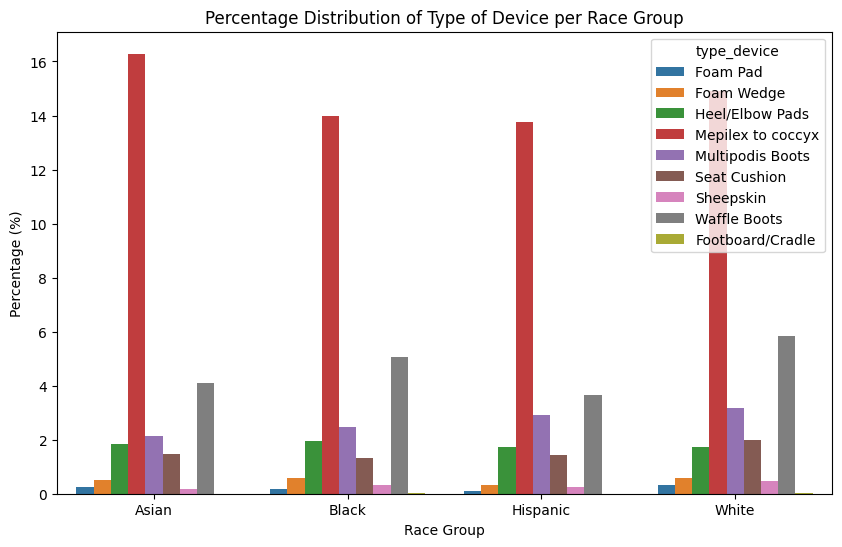

In [28]:
device_counts = ulcer_device.groupby(['race_group', 'type_device']).size().reset_index(name='counts')

# Calculate total subjects for each race_group
total_subjects = ulcer_device.groupby('race_group').size().reset_index(name='total')

# Merge the total_subjects dataframe with device_counts
device_counts = pd.merge(device_counts, total_subjects, on='race_group')

# Calculate the normalized percentages
device_counts['percentage'] = (device_counts['counts'] / device_counts['total']) * 100

# Create a barplot/histogram using seaborn
plt.figure(figsize=(10,6))
sns.barplot(x='race_group', y='percentage', hue='type_device', data=device_counts)

plt.title("Percentage Distribution of Type of Device per Race Group")
plt.ylabel("Percentage (%)")
plt.xlabel("Race Group")
plt.show()

## create the four groups

### Treatment
ulcer followed by device

In [29]:
treatment = ulcer_device[
    (ulcer_device['relevant_location'] == 1) &
    (ulcer_device['has_device'] == 1) &
    (ulcer_device['time_first_device_reported'] > ulcer_device['time_first_ulcer_reported'])
]


### Prophylaxis Failure
device followed by ulcer


In [30]:
prophylactic_failure_24 = ulcer_device[
    (ulcer_device['has_device'] == 1) &
    (ulcer_device['relevant_location'] == 1) &
    (ulcer_device['time_first_ulcer_reported'] > ulcer_device['time_first_device_reported'] + pd.Timedelta(hours=24))
]

prophylactic_failure_12 = ulcer_device[
    (ulcer_device['has_device'] == 1) &
    (ulcer_device['relevant_location'] == 1) &
    (ulcer_device['time_first_ulcer_reported'] > ulcer_device['time_first_device_reported'] + pd.Timedelta(hours=12))
]

prophylactic_failure_6 = ulcer_device[
    (ulcer_device['has_device'] == 1) &
    (ulcer_device['relevant_location'] == 1) &
    (ulcer_device['time_first_ulcer_reported'] > ulcer_device['time_first_device_reported'] + pd.Timedelta(hours=6))
]


### No prophylaxis, failure
ulcer followed by no device


In [31]:
no_treatment = ulcer_device[
    (ulcer_device['relevant_location'] == 1) & (ulcer_device['has_device'] == 0)
]


### Prophylaxis Success
device followed by no ulcer


In [32]:
prophylactic_success = ulcer_device[
    (ulcer_device['has_device'] == 1) & (ulcer_device['relevant_location'] == 0)
]


## assess the groups

In [33]:
# Dictionary of subsets
group_subsets = {
    "prophylactic_success": prophylactic_success,
    "prophylactic_failure_24": prophylactic_failure_24,
    "prophylactic_failure_12": prophylactic_failure_12,
    "prophylactic_failure_6": prophylactic_failure_6,
    "treatment": treatment,
    "no_treatment": no_treatment
}

# Get the number of patients for each group
patients_count = {}
for group, subset in group_subsets.items():
    patients_count[group] = subset['stay_id'].nunique()

print(str(patients_count)[1:-1].replace(",", "\n").replace("': ", ": "))



'prophylactic_success: 14172
 'prophylactic_failure_24: 689
 'prophylactic_failure_12: 811
 'prophylactic_failure_6: 954
 'treatment: 1738
 'no_treatment: 1817


## pivot as outcomes

In [34]:
# Creating the columns in the original dataframe based on the subsets

# Prophylactic success
ulcer_device['prophylactic_success'] = 0
ulcer_device.loc[ulcer_device['stay_id'].isin(prophylactic_success['stay_id']), 'prophylactic_success'] = 1

# Prophylactic failure 24 hours
ulcer_device['prophylactic_failure_24'] = 0
ulcer_device.loc[ulcer_device['stay_id'].isin(prophylactic_failure_24['stay_id']), 'prophylactic_failure_24'] = 1

# Prophylactic failure 12 hours
ulcer_device['prophylactic_failure_12'] = 0
ulcer_device.loc[ulcer_device['stay_id'].isin(prophylactic_failure_12['stay_id']), 'prophylactic_failure_12'] = 1

# Prophylactic failure 6 hours
ulcer_device['prophylactic_failure_6'] = 0
ulcer_device.loc[ulcer_device['stay_id'].isin(prophylactic_failure_6['stay_id']), 'prophylactic_failure_6'] = 1

# Treatment
ulcer_device['treatment'] = 0
ulcer_device.loc[ulcer_device['stay_id'].isin(treatment['stay_id']), 'treatment'] = 1

# No treatment
ulcer_device['no_treatment'] = 0
ulcer_device.loc[ulcer_device['stay_id'].isin(no_treatment['stay_id']), 'no_treatment'] = 1


In [35]:
ulcer_device.head()

,subject_id,hadm_id,stay_id,admission_age,race_group,gender,time_first_ulcer_reported,locations,time_first_device_reported,type_device,relevant_location,category_location,has_device,prophylactic_success,prophylactic_failure_24,prophylactic_failure_12,prophylactic_failure_6,treatment,no_treatment
0,10000032,29079034,39553978,52,White,F,NaT,None,NaT,None,0,,False,0,0,0,0,0,0
1,10000980,26913865,39765666,76,Black,F,NaT,None,2189-06-27 09:20:00,Multipodis Boots,0,,True,1,0,0,0,0,0
2,10001217,24597018,37067082,55,White,F,NaT,None,NaT,None,0,,False,0,0,0,0,0,0
3,10001217,27703517,34592300,55,White,F,NaT,None,NaT,None,0,,False,0,0,0,0,0,0
4,10001725,25563031,31205490,46,White,F,NaT,None,NaT,None,0,,False,0,0,0,0,0,0


In [38]:
df_table = ulcer_device[(ulcer_device.race_group != "Hispanic") & \
                        (ulcer_device.race_group != "Asian")]

cat = [
    'prophylactic_success',
    'treatment',
    'no_treatment'
]

nn = ['admission_age']

order = {
    'prophylactic_success': [1],
    'treatment': [1],
    'no_treatment': [1]
}

# Set limit for number of categories displayed for categorical variables
limit = {col: 1 for col in cat}


# Create tableone table
table = TableOne(df_table, columns=cat+nn, order=order, limit=limit,
                 groupby='race_group',
                 categorical=cat, nonnormal=nn,
                 missing=False,overall=False, pval=True)
table

Grouped by race_group                          
                                                Black             White P-Value
n                                                7960             49891        
prophylactic_success, n (%)   1           1645 (20.7)      11488 (23.0)  <0.001
treatment, n (%)              1             181 (2.3)        1455 (2.9)   0.001
no_treatment, n (%)           1             224 (2.8)        1509 (3.0)   0.323
admission_age, median [Q1,Q3]        63.0 [51.0,74.0]  68.0 [56.0,79.0]  <0.001